# Efficient Grammar Fuzzing

In the [chapter on grammars](Grammars.ipynb), we have seen how to use _grammars_ for very effective and efficient testing.  In this chapter, we refine the previous string-based algorithm into a tree-based algorithm, which is much faster and allows for much more control over the production of fuzz inputs.

The algorithm in this chapter serves as a foundation for several more techniques; this chapter thus is a "hub" in the book.

**Prerequisites**

* You should know how grammar-based fuzzing works, e.g. from the [chapter on grammars](Grammars.ipynb).

## An Insufficient Algorithm

In the [previous chapter](Grammars.ipynb), we have introduced the `simple_grammar_fuzzer()` function which takes a grammar and automatically produces a syntactically valid string from it.  However, `simple_grammar_fuzzer()` is just what its name suggests – simple.  To illustrate the problem, let us get back to the `expr_grammar` we created from `EXPR_GRAMMAR_BNF` in the [chapter on grammars](Grammars.ipynb):

In [1]:
import fuzzingbook_utils

In [2]:
from Grammars import EXPR_EBNF_GRAMMAR, convert_ebnf_grammar, simple_grammar_fuzzer

In [3]:
expr_grammar = convert_ebnf_grammar(EXPR_EBNF_GRAMMAR)
expr_grammar

{'<start>': ['<expr>'],
 '<expr>': ['<term> + <expr>', '<term> - <expr>', '<term>'],
 '<term>': ['<factor> * <term>', '<factor> / <term>', '<factor>'],
 '<factor>': ['<sign-1><factor>', '(<expr>)', '<integer><symbol-1-1>'],
 '<sign>': ['+', '-'],
 '<integer>': ['<digit-1>'],
 '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 '<symbol-1>': ['.<integer>'],
 '<sign-1>': ['', '<sign>'],
 '<symbol-1-1>': ['', '<symbol-1>'],
 '<digit-1>': ['<digit>', '<digit><digit-1>']}

`expr_grammar` has an interesting property.  If we feed it into `simple_grammar_fuzzer()`, the function gets stuck in an infinite expansion:

In [4]:
from ExpectError import ExpectTimeout

In [5]:
with ExpectTimeout(1):
    simple_grammar_fuzzer(grammar=expr_grammar, max_nonterminals=3)

Traceback (most recent call last):
  File "<ipython-input-5-fbcda5f486bb>", line 2, in <module>
    simple_grammar_fuzzer(grammar=expr_grammar, max_nonterminals=3)
  File "<string>", line 8, in simple_grammar_fuzzer
  File "/Users/zeller/anaconda3/lib/python3.6/random.py", line 256, in choice
    i = self._randbelow(len(seq))
  File "/Users/zeller/anaconda3/lib/python3.6/random.py", line 227, in _randbelow
    random = self.random
  File "/Users/zeller/anaconda3/lib/python3.6/random.py", line 227, in _randbelow
    random = self.random
  File "<string>", line 15, in check_time
TimeoutError (expected)


Why is that so?  The problem is in this rule:

In [6]:
expr_grammar['<factor>']

['<sign-1><factor>', '(<expr>)', '<integer><symbol-1-1>']

Here, any choice except for `(expr)` increases the number of symbols, even if only temporary.  Since we place a hard limit on the number of symbols to expand, the only choice left for expanding `<factor>` is `(<expr>)`, which leads to an infinite addition of parentheses.

The problem of potentially infinite expansion is only one of the problems with `simple_grammar_fuzzer()`.  More problems include:

1. *It is inefficient*.  With each iteration, this fuzzer would go search the string produced so far for symbols to expand.  This becomes inefficient as the production string grows.

2. *It is hard to control.*  Even while limiting the number of symbols, it is still possible to obtain very long strings – and even infinitely long ones, as discussed above.

Let us illustrate both problems by plotting the time required for strings of different lengths.

In [7]:
from Grammars import simple_grammar_fuzzer

In [8]:
from Grammars import START_SYMBOL, EXPR_GRAMMAR, URL_GRAMMAR, CGI_GRAMMAR

In [9]:
from Grammars import RE_NONTERMINAL, nonterminals, is_nonterminal

In [10]:
from Timer import Timer

In [11]:
trials = 50
xs = []
ys = []
for i in range(trials):
    with Timer() as t:
        s = simple_grammar_fuzzer(EXPR_GRAMMAR, max_nonterminals=15)
    xs.append(len(s))
    ys.append(t.elapsed_time())
    print(i, end=" ")
print()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


In [12]:
average_time = sum(ys) / trials
print("Average time:", average_time)

Average time: 0.23413591294083744


Text(0.5,1,'Time required for generating an output')

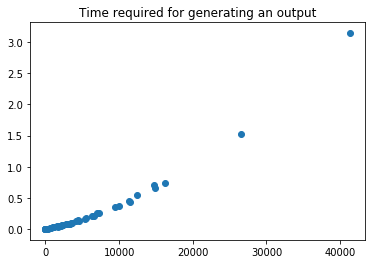

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.title('Time required for generating an output')

We see that (1) the effort increases quadratically over time, and (2) we can easily produce outputs that are tens of thousands of characters long.

To address these problem, we need a _smarter algorithm_ – one that is more efficient, that gets us better control over expansions, and that is able to foresee in `expr_grammar` that the `(expr)` alternative yields a potentially infinite expansion, in contrast to the other two.

## Derivation Trees

To both obtain a more efficient algorithm _and_ exercise better control over expansions, we will use a special representation for the strings that our grammar produces.  The general idea is to use a _tree_ structure that will be subsequently expanded – a so-called _derivation tree_.

Like other trees used in programming, a derivation tree consists of _nodes_ which have other nodes as their _children_.  The tree starts with one node that has no parent; this is called the _root node_; a node without children is called a _leaf_.

The grammar expansion process with derivation trees is illustrated in the following steps, using the arithmetic grammar [from
the chapter on grammars](Grammars.ipynb).  We start with a single node as root of the tree, representing the _start symbol_ – in our case `<start>`.

(We use `dot` as a drawing program; you don't need to look at the code, just at its results.)

In [14]:
from graphviz import Digraph

In [15]:
tree = Digraph("root")
tree.attr('node', shape='plain')
tree.node(r"\<start\>")

In [16]:
tree

To expand the tree, we traverse it, searching for a symbol $S$ without children to expand, and chose an expansion for $S$ from the grammar.  Then, we add the expansion as a new child of $S$.  In the case of our start symbol `<start>`, its only expansion is `<expr>`, so we add this as a child.

In [17]:
tree.edge(r"\<start\>", r"\<expr\>")

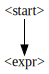

In [18]:
tree

To construct the produced string from a derivation tree, we traverse the tree in order and collect the symbols at the leaves of the tree.  In the case above, we obtain the string `"<expr>"`.

To further expand the tree, we choose another symbol to expand, and add its expansion as new children.  This would get us the `<expr>` symbol, which gets expanded into `<expr> + <term>`, adding three children.

In [19]:
tree.edge(r"\<expr\>", r"\<expr\> ")
tree.edge(r"\<expr\>", r"+")
tree.edge(r"\<expr\>", r"\<term\>")

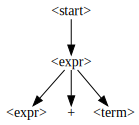

In [20]:
tree

We repeat the expansion until there are no symbols left to expand:

In [21]:
tree.edge(r"\<expr\> ", r"\<term\> ")
tree.edge(r"\<term\> ", r"\<factor\> ")
tree.edge(r"\<factor\> ", r"\<integer\> ")
tree.edge(r"\<integer\> ", r"\<digit\> ")
tree.edge(r"\<digit\> ", r"2 ")

tree.edge(r"\<term\>", r"\<factor\>")
tree.edge(r"\<factor\>", r"\<integer\>")
tree.edge(r"\<integer\>", r"\<digit\>")
tree.edge(r"\<digit\>", r"2")

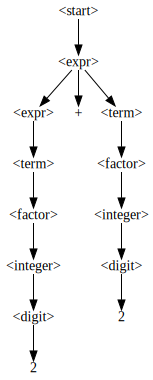

In [22]:
tree

We now have a representation for the string `2 + 2`.  In contrast to the string alone, though, the derivation tree records _the entire structure_ (and production history, or _derivation_ history) of the produced string.  It also allows for simple comparison and manipulation – say, replacing one subtree (substructure) against another.

## Representing Derivation Trees

To represent a derivation tree in Python, we use the following format.  A node is a pair

```python
(SYMBOL_NAME, CHILDREN)
```

where `SYMBOL_NAME` is a string representing the node (i.e. `"<start>"` or `"+"`) and `CHILDREN` is a list of children nodes.

`CHILDREN` can take some special values:

1. `None` as a placeholder for future expansion.  This means that the node is a _nonterminal symbol_ that should be expanded further.
2. `[]` (i.e., the empty list) to indicate _no_ children.  This means that the node is a _terminal symbol_ that can no longer be expanded.

Let us take a very simple derivation tree, representing the intermediate step `<expr> + <term>`, above.

In [23]:
derivation_tree = ("<start>",
                   [("<expr>",
                     [("<expr>", None),
                      (" + ", []),
                         ("<term>", None)]
                     )])

To better understand the structure of this tree, let us introduce a function that visualizes this tree.  We use the `dot` drawing program from the `graphviz` package algorithmically, traversing the above structure.  (Unless you're deeply interested in tree visualization, you can directly skip to the example below.)

In [24]:
from graphviz import Digraph

In [25]:
from IPython.display import display

In [26]:
import re

In [27]:
def dot_escape(s):
    """Return s in a form suitable for dot"""
    # s = s.replace("\\", "\\\\")
    s = re.sub(r"([^a-zA-Z0-9 ])", r"\\\1", s)
    return s

In [28]:
assert dot_escape("hello") == "hello"
assert dot_escape("<hello>, world") == "\\<hello\\>\\, world"
assert dot_escape("\\n") == "\\\\n"

In [29]:
def display_tree(derivation_tree):
    """Visualize a derivation tree as SVG using the graphviz/dot package."""

    counter = 0

    def traverse_tree(dot, tree, id=0):
        (symbol, children) = tree
        dot.node(repr(id), dot_escape(symbol))

        if children is not None:
            for child in children:
                nonlocal counter  # Assign each node a unique identifier
                counter += 1
                child_id = counter
                dot.edge(repr(id), repr(child_id))
                traverse_tree(dot, child, child_id)

    dot = Digraph(comment="Derivation Tree")
    dot.attr('node', shape='plain')
    traverse_tree(dot, derivation_tree)
    display(dot)


This is what our tree visualizes into:

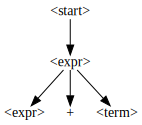

In [30]:
display_tree(derivation_tree)

To turn the tree into a string, the following `all_terminals()` function comes in handy:

In [31]:
def all_terminals(tree):
    (symbol, children) = tree
    if children is None:
        # This is a nonterminal symbol not expanded yet
        return symbol

    if len(children) == 0:
        # This is a terminal symbol
        return symbol

    # This is an expanded symbol:
    # Concatenate all terminal symbols from all children
    return ''.join([all_terminals(c) for c in children])

In [32]:
all_terminals(derivation_tree)

'<expr> + <term>'

## Expanding a Node

Let us now develop an algorithm that takes a tree with unexpanded symbols (say, `derivation_tree`, above), and expands all these symbols one after the other.  As with earlier fuzzers, we create a special subclass of `Fuzzer` – in this case, `GrammarFuzzer`.  A `GrammarFuzzer` gets a grammar and a start symbol; the other parameters will be used later to further control creation and to support debugging.

In [33]:
from Fuzzer import Fuzzer

In [34]:
class GrammarFuzzer(Fuzzer):
    def __init__(self, grammar, start_symbol=START_SYMBOL,
                 min_nonterminals=0, max_nonterminals=10, disp=False, log=False):
        self.grammar = grammar
        self.start_symbol = start_symbol
        self.min_nonterminals = min_nonterminals
        self.max_nonterminals = max_nonterminals
        self.disp = disp
        self.log = log


In the following, we will add further methods to `GrammarFuzzer`, using the hack already introduced for [the `MutationFuzzer` class](MutationFuzzer.ipynb).  The construct

```python
class GrammarFuzzer(GrammarFuzzer):
    def new_method(self, args):
        pass
```

allows us to add a new method `new_method()` to the `GrammarFuzzer` class. (Actually, we get a new `GrammarFuzzer` class that extends the old one, but for all our purposes, this does not matter.)

Using this hack, let us define a helper method `init_tree()` that constructs a tree with just the start symbol:

In [35]:
class GrammarFuzzer(GrammarFuzzer):
    def init_tree(self):
        return (self.start_symbol, None)

In [36]:
f = GrammarFuzzer(EXPR_GRAMMAR)
display_tree(f.init_tree())

Next, we will need a helper function `expansion_to_children()` that takes an expansion string and converts it into a list of derivation trees.  It uses the `re.split()` method to split an expansion string into a list of children nodes:

In [37]:
def expansion_to_children(expansion):
    # print("Converting " + repr(expansion))
    # strings contains all substrings -- both terminals and non-terminals such
    # that ''.join(strings) == expansion

    # See nonterminals() in Grammars.py
    if isinstance(expansion, tuple):
        expansion = expansion[0]

    if expansion == "":  # Special case: empty expansion
        return [("", [])]

    strings = re.split(RE_NONTERMINAL, expansion)
    return [(s, None) if is_nonterminal(s) else (s, [])
            for s in strings if len(s) > 0]


In [38]:
expansion_to_children("<term> + <expr>")

[('<term>', None), (' + ', []), ('<expr>', None)]

The case of an empty expansion needs special treatment:

In [39]:
expansion_to_children("")

[('', [])]

Just like `nonterminals()` in the [chapter on Grammars](Grammars.ipynb), we provide for future extensions, allowing the expansion to be a tuple with extra data (which will be ignored).

In [40]:
expansion_to_children(("+<term>", ["extra_data"]))

[('+', []), ('<term>', None)]

We realize this helper as a method in `GrammarFuzzer` such that it can be overloaded by subclasses:

In [41]:
class GrammarFuzzer(GrammarFuzzer):
    def expansion_to_children(self, expansion):
        return expansion_to_children(expansion)

With this, we can now take some unexpanded node in the tree, choose a random expansion, and return the new tree.  This is what the method `expand_node_randomly()` does, using a helper function `choose_node_expansion()` to randomly pick an index from an array of possible children.  (`choose_node_expansion()` can be overloaded in subclasses.)

In [42]:
import random

In [43]:
class GrammarFuzzer(GrammarFuzzer):
    def choose_node_expansion(self, node, possible_children):
        """Return index of expansion in `possible_children` to be selected.  Defaults to random."""
        return random.randrange(0, len(possible_children))

    def expand_node_randomly(self, node):
        (symbol, children) = node
        assert children is None

        if self.log:
            print("Expanding", all_terminals(node), "randomly")

        # Fetch the possible expansions from grammar...
        expansions = self.grammar[symbol]
        possible_children = [self.expansion_to_children(expansion) for expansion in expansions]

        # ... and select a random expansion
        index = self.choose_node_expansion(node, possible_children)
        children = possible_children[index]

        # Return with new children
        return (symbol, children)


The generic `expand_node()` method can later be used to select different expansion strategies; as of now, it only uses `expand_node_randomly()`.

In [44]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node(self, node):
        return self.expand_node_randomly(node)

This is how `expand_node_randomly()` works:

Before:


After:
Expanding <term> randomly


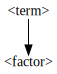

In [45]:
f = GrammarFuzzer(EXPR_GRAMMAR, log=True)

print("Before:")
tree = ("<term>", None)
display_tree(tree)

print("After:")
tree = f.expand_node_randomly(tree)
display_tree(tree)

## Expanding a Tree

Let us now apply the above node expansion to some node in the tree.  To this end, we first need to search the tree for unexpanded nodes.  `possible_expansions()` counts how many unexpanded symbols there are in a tree:

In [46]:
class GrammarFuzzer(GrammarFuzzer):
    def possible_expansions(self, node):
        (symbol, children) = node
        if children is None:
            return 1

        return sum(self.possible_expansions(c) for c in children)

In [47]:
f = GrammarFuzzer(EXPR_GRAMMAR)
print(f.possible_expansions(derivation_tree))

2


The method `any_possible_expansions()` returns True if the tree has any unexpanded nodes.

In [48]:
class GrammarFuzzer(GrammarFuzzer):
    def any_possible_expansions(self, node):
        (symbol, children) = node
        if children is None:
            return True

        return any(self.any_possible_expansions(c) for c in children)

In [49]:
f = GrammarFuzzer(EXPR_GRAMMAR)
f.any_possible_expansions(derivation_tree)

True

Here comes `expand_tree_once()`, the core method of our tree expansion algorithm.  It first checks whether it is currently being applied on a nonterminal symbol without expansion; if so, it invokes `expand_node()` on it as above.  

If the node is already expanded (i.e. has children), it checks the subset of children which still have unexpanded symbols; randomly selects one of them, and applies itself recursively on that child.

The `expand_tree_once()` method replaces the child _in place_, meaning that it actually mutates the tree being passed as an argument rather than returning a new tree.  This in-place mutation is what makes this function particularly efficient.  Again, we use a helper method (`choose_tree_expansion()`) to return the chosen index from a list of children that can be expanded.

In [50]:
class GrammarFuzzer(GrammarFuzzer):
    def choose_tree_expansion(self, tree, children):
        """Return index of subtree in `children` to be selected for expansion.  Defaults to random."""
        return random.randrange(0, len(children))

    def expand_tree_once(self, tree):
        (symbol, children) = tree
        if children is None:
            # Expand this node
            return self.expand_node(tree)

        # Find all children with possible expansions
        expandable_children = [
            c for c in children if self.any_possible_expansions(c)]

        # `index_map` translates an index in `expandable_children`
        # back into the original index in `children`
        index_map = [i for (i, c) in enumerate(children)
                     if self.any_possible_expansions(c)]

        # Select a random child
        child_to_be_expanded = self.choose_tree_expansion(
            tree, expandable_children)

        # Expand in place
        children[index_map[child_to_be_expanded]] = \
            self.expand_tree_once(expandable_children[child_to_be_expanded])

        return tree

Let's put it to use, expanding our derivation tree from above twice.

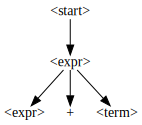

In [51]:
derivation_tree = ("<start>",
                   [("<expr>",
                     [("<expr>", None),
                      (" + ", []),
                         ("<term>", None)]
                     )])
display_tree(derivation_tree)

Expanding <expr> randomly


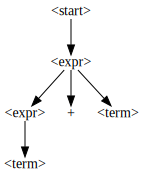

In [52]:
f = GrammarFuzzer(EXPR_GRAMMAR, log=True)
derivation_tree = f.expand_tree_once(derivation_tree)
display_tree(derivation_tree)

Expanding <term> randomly


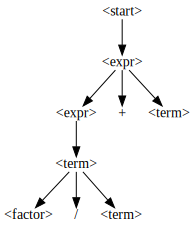

In [53]:
derivation_tree = f.expand_tree_once(derivation_tree)
display_tree(derivation_tree)

We see that which each step, one more symbol is expanded.  Now all it takes is to apply this again and again, expanding the tree further and further.

## Closing the Expansion

With `expand_tree_once()`, we can keep on expanding the tree – but how do we actually stop?  The key idea here, introduced by Luke in \cite{Luke2000}, is that after inflating the derivation tree to some maximum size, we _only want to apply expansions that increase the size of the tree by a minimum_.  For `<factor>`, for instance, we would prefer an expansion into `<integer>`, as this will not introduce further recursion (and potential size inflation); for `<integer>`, likewise, an expansion into `<digit>` is preferred, as it will less increase tree size than `<digit><integer>`.

To identify the _cost_ of expanding a symbol, we introduce two functions that mutually rely on each other:

* `symbol_cost()` returns the minimum cost of all expansions of a symbol, using `expansion_cost()` to compute the cost for each expansion.
* `expansion_cost()` returns the sum of all expansions in `expansions`.  If a nonterminal is encountered again during traversal, the cost of the expansion is $\infty$, indicating (potentially infinite) recursion.

In [54]:
class GrammarFuzzer(GrammarFuzzer):
    def symbol_cost(self, symbol, seen=set()):
        expansions = self.grammar[symbol]
        return min(self.expansion_cost(e, seen | {symbol}) for e in expansions)

    def expansion_cost(self, expansion, seen=set()):
        symbols = nonterminals(expansion)
        if len(symbols) == 0:
            return 1  # no symbol

        if any(s in seen for s in symbols):
            return float('inf')

        # the value of a expansion is the sum of all expandable variables
        # inside + 1
        return sum(self.symbol_cost(s, seen) for s in symbols) + 1

Here's two examples: The minimum cost of expanding a digit is 1, since we have to choose between one of its expansions.

In [55]:
f = GrammarFuzzer(EXPR_GRAMMAR)
assert f.symbol_cost("<digit>") == 1

The minimum cost of expanding `<expr>`, though, is five, as this is the minimum number of expansions required.  (`<expr>` $\rightarrow$ `<term>` $\rightarrow$ `<factor>` $\rightarrow$ `<integer>` $\rightarrow$ `<digit>` $\rightarrow$ 1)

In [56]:
assert f.symbol_cost("<expr>") == 5

Here's now a variant of `expand_node()` that takes the above cost into account.  It determines the minimum cost `cost` across all children and then chooses a child from the list using the `choose` function, which by default is the minimum cost.  If multiple children all have the same minimum cost, it chooses randomly between these.

In [57]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node_by_cost(self, node, choose=min):
        (symbol, children) = node
        assert children is None

        # Fetch the possible expansions from grammar...
        expansions = self.grammar[symbol]

        possible_children_with_cost = [(self.expansion_to_children(expansion),
                                        self.expansion_cost(expansion, {symbol}))
                                       for expansion in expansions]

        costs = [cost for (child, cost) in possible_children_with_cost]
        chosen_cost = choose(costs)
        children_with_chosen_cost = [child for (child, child_cost) in possible_children_with_cost
                                     if child_cost == chosen_cost]

        index = self.choose_node_expansion(node, children_with_chosen_cost)

        # Return with a new list
        return (symbol, children_with_chosen_cost[index])


The shortcut `expand_node_min_cost()` passes `min()` as the `choose` function, which makes it expand nodes at minimum cost.

In [58]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node_min_cost(self, node):
        if self.log:
            print("Expanding", all_terminals(node), "at minimum cost")

        return self.expand_node_by_cost(node, min)

We can now apply this function to close the expansion of our derivation tree, using `expand_tree_once()` with the above `expand_node_min_cost()` as expansion function.

In [59]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node(self, node):
        return self.expand_node_min_cost(node)

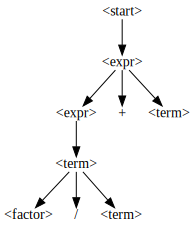

In [60]:
f = GrammarFuzzer(EXPR_GRAMMAR, log=True)
display_tree(derivation_tree)

Expanding <factor> at minimum cost


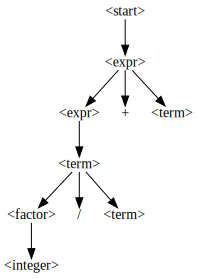

In [61]:
if f.any_possible_expansions(derivation_tree):
    derivation_tree = f.expand_tree_once(derivation_tree)
    display_tree(derivation_tree)

Expanding <term> at minimum cost


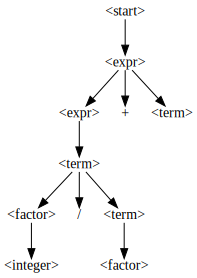

In [62]:
if f.any_possible_expansions(derivation_tree):
    derivation_tree = f.expand_tree_once(derivation_tree)
    display_tree(derivation_tree)

Expanding <term> at minimum cost


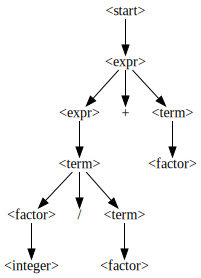

In [63]:
if f.any_possible_expansions(derivation_tree):
    derivation_tree = f.expand_tree_once(derivation_tree)
    display_tree(derivation_tree)

We keep on expanding until all nonterminals are expanded.

In [64]:
while f.any_possible_expansions(derivation_tree):
    derivation_tree = f.expand_tree_once(derivation_tree)    

Expanding <factor> at minimum cost
Expanding <integer> at minimum cost
Expanding <factor> at minimum cost
Expanding <integer> at minimum cost
Expanding <integer> at minimum cost
Expanding <digit> at minimum cost
Expanding <digit> at minimum cost
Expanding <digit> at minimum cost


Here is the final tree:

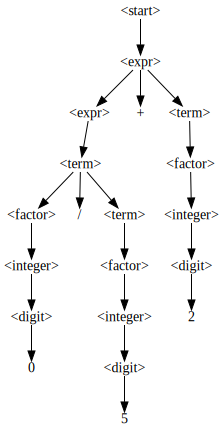

In [65]:
display_tree(derivation_tree)

We see that in each step, `expand_node_min_cost()` chooses an expansion that does not increase the number of symbols, eventually closing all open expansions.

## Node Inflation

Especially at the beginning of an expansion, we may be interested in getting _as many nodes as possible_ – that is, we'd like to prefer expansions that give us _more_ nonterminals to expand.  This is actually the exact opposite from what `expand_node_min_cost()` gives us, and we can implement a method `expand_node_max_cost()` that will always choose among the nodes with the _highest_ cost:

In [66]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node_max_cost(self, node):
        if self.log:
            print("Expanding", all_terminals(node), "at maximum cost")

        return self.expand_node_by_cost(node, max)

To illustrate `expand_node_max_cost()`, we can again redefine `expand_node()` to use it, and then use `expand_tree_once()` to show a few expansion steps:

In [67]:
class GrammarFuzzer(GrammarFuzzer):
    def expand_node(self, node):
        return self.expand_node_max_cost(node)

In [68]:
derivation_tree = ("<start>",
                   [("<expr>",
                     [("<expr>", None),
                      (" + ", []),
                         ("<term>", None)]
                     )])

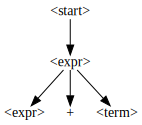

In [69]:
f = GrammarFuzzer(EXPR_GRAMMAR, log=True)
display_tree(derivation_tree)

Expanding <term> at maximum cost


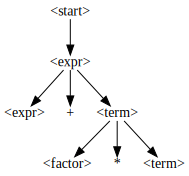

In [70]:
if f.any_possible_expansions(derivation_tree):
    derivation_tree = f.expand_tree_once(derivation_tree)
    display_tree(derivation_tree)

Expanding <term> at maximum cost


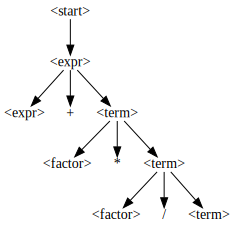

In [71]:
if f.any_possible_expansions(derivation_tree):
    derivation_tree = f.expand_tree_once(derivation_tree)
    display_tree(derivation_tree)

Expanding <expr> at maximum cost


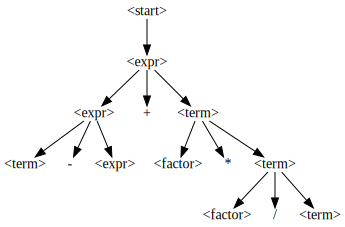

In [72]:
if f.any_possible_expansions(derivation_tree):
    derivation_tree = f.expand_tree_once(derivation_tree)
    display_tree(derivation_tree)

We see that with each step, the number of nonterminals increases.  Obviously, we have to put a limit on this number.

## Three Expansion Phases

We can now put all three phases together in a single function `expand_tree()` which will work as follows:

1. **Max cost expansion.** Expand the tree using expansions with maximum cost until we have at least `min_nonterminals` nonterminals.  This phase can be easily skipped by setting `min_nonterminals` to zero.
2. **Random expansion.**  Keep on expanding the tree randomly until we reach `max_nonterminals` nonterminals.
3. **Min cost expansion.** Close the expansion with minimum cost.

We implement these three phases by having `expand_node` reference the expansion method to apply.  This is controlled by setting `expand_node` (the method reference) to first `expand_node_max_cost` (i.e., calling `expand_node()` invokes `expand_node_max_cost()`), then `expand_node_randomly`, and finally `expand_node_min_cost`.  In the first two phases, we also set a maximum limit of `min_nonterminals` and `max_nonterminals`, respectively.

In [73]:
class GrammarFuzzer(GrammarFuzzer):
    def log_tree(self, tree):
        """Output a tree if self.log is set; if self.display is also set, show the tree structure"""
        if self.log:
            print("Tree:", all_terminals(tree))
            if self.disp:
                display_tree(tree)
            # print(self.possible_expansions(tree), "possible expansion(s) left")

    def expand_tree_with_strategy(self, tree, expand_node_method, limit=None):
        """Expand tree using `expand_node_method` as node expansion function
        until the number of possible expansions reaches `limit`."""
        self.expand_node = expand_node_method
        while (limit is None or self.possible_expansions(tree)
               < limit) and self.any_possible_expansions(tree):
            tree = self.expand_tree_once(tree)
            self.log_tree(tree)
        return tree

    def expand_tree(self, tree):
        """Expand `tree` in a three-phase strategy until all expansions are complete."""
        self.log_tree(tree)
        tree = self.expand_tree_with_strategy(
            tree, self.expand_node_max_cost, self.min_nonterminals)
        tree = self.expand_tree_with_strategy(
            tree, self.expand_node_randomly, self.max_nonterminals)
        tree = self.expand_tree_with_strategy(tree, self.expand_node_min_cost)

        assert self.possible_expansions(tree) == 0

        return tree


Let us try this out on our example.

In [74]:
derivation_tree = ("<start>",
                   [("<expr>",
                     [("<expr>", None),
                      (" + ", []),
                         ("<term>", None)]
                     )])

f = GrammarFuzzer(
    EXPR_GRAMMAR,
    min_nonterminals=3,
    max_nonterminals=5,
    log=True)
derivation_tree = f.expand_tree(derivation_tree)

Tree: <expr> + <term>
Expanding <expr> at maximum cost
Tree: <term> - <expr> + <term>
Expanding <term> randomly
Tree: <term> - <expr> + <factor> / <term>
Expanding <term> randomly
Tree: <term> - <expr> + <factor> / <factor>
Expanding <expr> randomly
Tree: <term> - <term> + <factor> / <factor>
Expanding <factor> randomly
Tree: <term> - <term> + <factor> / <integer>.<integer>
Expanding <term> at minimum cost
Tree: <term> - <factor> + <factor> / <integer>.<integer>
Expanding <factor> at minimum cost
Tree: <term> - <factor> + <integer> / <integer>.<integer>
Expanding <integer> at minimum cost
Tree: <term> - <factor> + <digit> / <integer>.<integer>
Expanding <factor> at minimum cost
Tree: <term> - <integer> + <digit> / <integer>.<integer>
Expanding <integer> at minimum cost
Tree: <term> - <integer> + <digit> / <integer>.<digit>
Expanding <term> at minimum cost
Tree: <factor> - <integer> + <digit> / <integer>.<digit>
Expanding <digit> at minimum cost
Tree: <factor> - <integer> + <digit> / <i

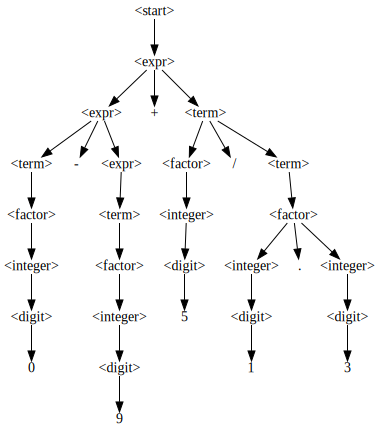

In [75]:
display_tree(derivation_tree)

In [76]:
all_terminals(derivation_tree)

'0 - 9 + 5 / 1.3'

## Putting it all Together

Based on this, we can now define a function `fuzz()` that – like `simple_grammar_fuzzer()` – simply takes a grammar and produces a string from it.  It thus no longer exposes the complexity of derivation trees.

In [77]:
class GrammarFuzzer(GrammarFuzzer):
    def fuzz_tree(self):
        # Create an initial derivation tree
        tree = self.init_tree()
        # print(tree)

        # Expand all nonterminals
        tree = self.expand_tree(tree)
        if self.log:
            print(repr(all_terminals(tree)))
        if self.disp:
            display_tree(tree)
        return tree

    def fuzz(self):
        self.derivation_tree = self.fuzz_tree()
        return all_terminals(self.derivation_tree)

We can now apply this on all our defined grammars (and visualize the derivation tree along)

In [78]:
f = GrammarFuzzer(EXPR_GRAMMAR)
f.fuzz()

'(7 + 1) * 8 / -6 - 8 / 9 * 3 / 5 - 6 / 1'

After calling `fuzz()`, the produced derivation tree is accessible in the `derivation_tree` attribute:

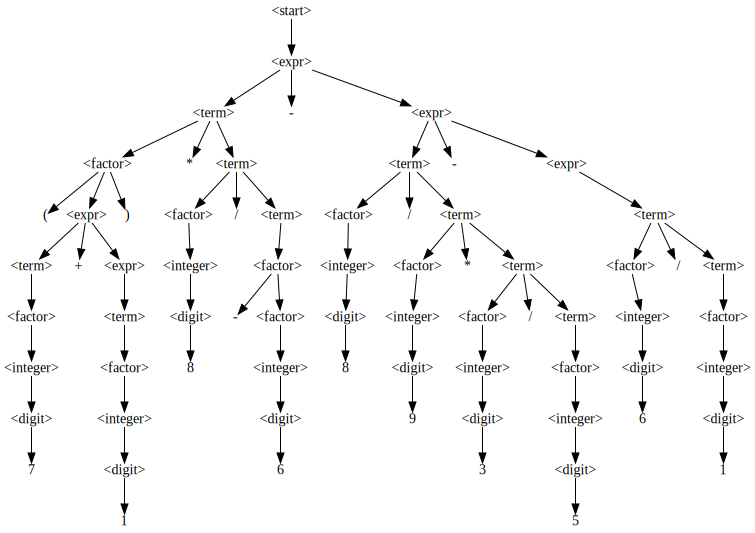

In [79]:
display_tree(f.derivation_tree)

Let us try out the grammar fuzzer (and its trees) on other grammar formats.

In [80]:
f = GrammarFuzzer(URL_GRAMMAR)
f.fuzz()

'ftp://www.google.com/x89'

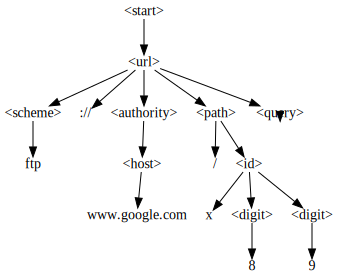

In [81]:
display_tree(f.derivation_tree)

In [82]:
f = GrammarFuzzer(CGI_GRAMMAR, min_nonterminals=3, max_nonterminals=5)
f.fuzz()

'%8b%28%c3'

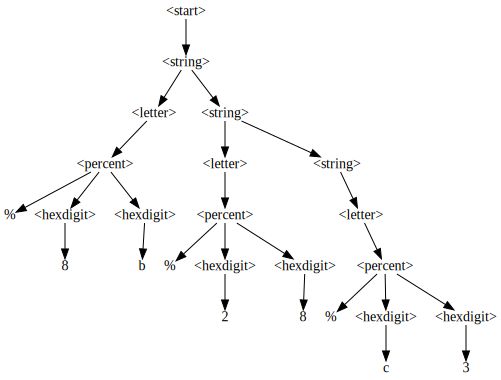

In [83]:
display_tree(f.derivation_tree)

How do we stack up against `simple_grammar_fuzzer()`?

In [84]:
trials = 50
xs = []
ys = []
f = GrammarFuzzer(EXPR_GRAMMAR, max_nonterminals=20)
for i in range(trials):
    with Timer() as t:
        s = f.fuzz()
    xs.append(len(s))
    ys.append(t.elapsed_time())
    print(i, end=" ")
print()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 


In [85]:
average_time = sum(ys) / trials
print("Average time:", average_time)

Average time: 0.0462096054002177


Text(0.5,1,'Time required for generating an output')

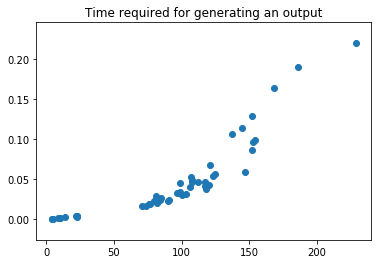

In [86]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.title('Time required for generating an output')

Our test generation is much faster, but also our inputs are much smaller.  We see that with derivation trees, we can get much better control over grammar production.

Finally, how does `GrammarFuzzer` work with `expr_grammar`, where `simple_grammar_fuzzer()` failed?  It works without any issue:

In [87]:
f = GrammarFuzzer(expr_grammar, max_nonterminals=10)
f.fuzz()

'(9) / 9 / 0 / 3 * 1 + 1 / 0 - 8'

With `GrammarFuzzer`, we now have a solid foundation on which to build further fuzzers and illustrate more exciting concepts from the world of generating software tests.  Many of these do not even require writing a grammar – instead, they _infer_ a grammar from the domain at hand, and thus allow to use grammar-based fuzzing even without writing a grammar.  Stay tuned!

## Lessons Learned

* _Derivation trees_ are important for expressing input structure
* _Grammar fuzzing based on derivation trees_ 
    1. is much more efficient than string-based grammar fuzzing,
    2. gives much better control over input generation, and
    3. effectively avoids running into infinite expansions.

## Next Steps

Congratulations!  You have reached one of the central "hubs" of the book.  From here, there is a wide range of techniques that build on grammar fuzzing.

### Extending Grammars

First, we have a number of techniques that all _extend_ grammars in some form:

* [Parsing and recombining inputs](Parser.ipynb) allows to make use of existing inputs, again using derivation trees
* [Covering grammar expansions](GrammarCoverageFuzzer.ipynb) allows for _combinatorial_ coverage
* [Assigning _probabilities_ to individual expansions](ProbabilisticGrammarFuzzer.ipynb) gives additional control over expansions
* [Assigning _constraints_ to individual expansions](ConstraintGrammarFuzzer.ipynb) allows to express _semantic constraints_ on individual rules.

### Applying Grammars

Second, we can _apply_ grammars in a variety of contexts that all involve some form of learning it automatically:

* [Fuzzing APIs](APIFuzzer.ipynb), learning a grammar from APIs
* [Fuzzing GUIs](GUIFuzzer.ipynb), learning a grammar from user interfaces for subsequent fuzzing
* [Mining Grammars](GrammarMiner.ipynb), learning a grammar for arbitrary input formats

Keep on expanding!

## Background

\todo{Discuss derivation trees.}

The key idea in this chapter, namely expanding until a limit of symbols is reached, and then always choosing the shortest path, stems from Luke \cite{Luke2000}.

## Exercises

### Exercise 1: Caching Method Results

Tracking `GrammarFuzzer` reveals that some methods are called again and again, always with the same values.  

Set up a class `FasterGrammarFuzzer` with a _cache_ that checks whether the method has been called before, and if so, return the previously computed "memoized" value.  Do this for `expansion_to_children()`.  Compare the number of invocations before and after the optimization.

**Important**: For `expansion_to_children()`, make sure that each list returned is an individual copy.  If you return the sane (cached) list, this will interfere with the in-place modification of `GrammarFuzzer`.  Use the Python `copy.deepcopy()` function for this purpose.

**Solution.** Let us demonstrate this for `expansion_to_children()`:

In [88]:
from copy import deepcopy

In [89]:
class FasterGrammarFuzzer(GrammarFuzzer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._expansion_cache = {}
        self._expansion_invocations = 0
        self._expansion_invocations_cached = 0

    def expansion_to_children(self, expansion):
        self._expansion_invocations += 1
        if expansion in self._expansion_cache:
            self._expansion_invocations_cached += 1
            cached_result = deepcopy(self._expansion_cache[expansion])
            return cached_result

        result = super().expansion_to_children(expansion)
        self._expansion_cache[expansion] = result
        return result

In [90]:
f = FasterGrammarFuzzer(EXPR_GRAMMAR, min_nonterminals=3, max_nonterminals=5)
f.fuzz()

'9.9 * 9 * 9 - 9'

In [91]:
f._expansion_invocations

59

In [92]:
f._expansion_invocations_cached

35

In [93]:
print("%.2f%% of invocations can be cached" %
      (f._expansion_invocations_cached * 100 / f._expansion_invocations))

59.32% of invocations can be cached


### Exercise 2: Grammar Pre-Compilation

Some methods such as `symbol_cost()` or `expansion_cost()` return a value that is dependent on the grammar only.  Set up a class `EvenFasterGrammarFuzzer()` that pre-computes these values once upon initialization, such that later invocations of `symbol_cost()` or `expansion_cost()` need only look up these values.

**Solution.** Here's a possible solution, using a hack to substitute the `symbol_cost()` and `expansion_cost()` functions once the pre-computed values are set up.

In [94]:
class EvenFasterGrammarFuzzer(GrammarFuzzer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._symbol_costs = {}
        self._expansion_costs = {}
        self.precompute_costs()

    def new_symbol_cost(self, symbol, seen=set()):
        return self._symbol_costs[symbol]

    def new_expansion_cost(self, expansion, seen=set()):
        return self._expansion_costs[expansion]

    def precompute_costs(self):
        for symbol in self.grammar:
            self._symbol_costs[symbol] = super().symbol_cost(symbol)
            for expansion in self.grammar[symbol]:
                self._expansion_costs[expansion] = super(
                ).expansion_cost(expansion)

        # Make sure we now call the caching methods
        self.symbol_cost = self.new_symbol_cost
        self.expansion_cost = self.new_expansion_cost

In [95]:
f = EvenFasterGrammarFuzzer(EXPR_GRAMMAR)

Here are the individual costs:

In [96]:
f._symbol_costs

{'<start>': 6,
 '<expr>': 5,
 '<term>': 4,
 '<factor>': 3,
 '<integer>': 2,
 '<digit>': 1}

In [97]:
f._expansion_costs

{'<expr>': 6,
 '<term> + <expr>': 10,
 '<term> - <expr>': 10,
 '<term>': 5,
 '<factor> * <term>': 8,
 '<factor> / <term>': 8,
 '<factor>': 4,
 '+<factor>': 4,
 '-<factor>': 4,
 '(<expr>)': 6,
 '<integer>.<integer>': 5,
 '<integer>': 3,
 '<digit><integer>': 4,
 '<digit>': 2,
 '0': 1,
 '1': 1,
 '2': 1,
 '3': 1,
 '4': 1,
 '5': 1,
 '6': 1,
 '7': 1,
 '8': 1,
 '9': 1}

In [98]:
f = EvenFasterGrammarFuzzer(EXPR_GRAMMAR)
f.fuzz()

'-7 / (++9.8 * -4 + -+36.249344) + 8.5 * ++--2'

### Exercise 3: Maintaining Trees to be Expanded

In `expand_tree_once()`, the algorithm traverses the tree again and again to find nonterminals that still can be extended.  Speed up the process by keeping a list of nonterminal symbols in the tree that still can be expanded.

**Solution.** Left as exercise for the reader.

### Exercise 4: Alternate Random Expansions

We could define `expand_node_randomly()` such that it simply invokes `expand_node_by_cost(node, random.choice)`:

In [99]:
class ExerciseGrammarFuzzer(GrammarFuzzer):
    def expand_node_randomly(self, node):
        if self.log:
            print("Expanding", all_terminals(node), "randomly by cost")

        return self.expand_node_by_cost(node, random.choice)

What is the difference between the original implementation and this alternative?

**Solution.** The alternative in `ExerciseGrammarFuzzer` has another probability distribution.  In the original `GrammarFuzzer`, all expansions have the same likelihood of being expanded.  In `ExerciseGrammarFuzzer`, first, a cost is chosen (randomly); then, one of the expansions with this cost is chosen (again randomly).  This means that expansions whose cost is unique have a higher chance of being selected.